<a href="https://colab.research.google.com/github/Tom-Yuen/TomY_Little_Projects/blob/main/UK_Fuel_Poverty_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This project aims to look into the latest Fuel Poverty Dataset released by gov in April 2024. For example, we want to see if there's a significant difference between different regions or LA. We also want to look into the South West regions and draw some insights.
## Read the file from the gov.uk site instead of downloading it into local machine.
## Quick clean up, delete top rows to get the table we need, and delete unrelated rows.

In [2]:
import pandas as pd

# URL of the Excel file
url = "https://assets.publishing.service.gov.uk/media/663a29608603389a07a6d1b4/2024_Sub-Regional_Tables_Final.xlsx"

# Read the Excel file, skip the first 2 rows, and use the third row as header
df = pd.read_excel(url, sheet_name="Table 3", skiprows=2, header=0)

# Drop the row where 'LSOA' column has the value 'Back to contents'
df = df[df['LSOA Code'] != 'Back to contents']

# Drop the row where 'Proportion of households fuel poor (%)' is 'England'
df = df[df['Proportion of households fuel poor (%)'] != 'England']

# Dropping rows with any missing values (blanks)
df = df.dropna()

# Change the type of 'Proportion of households fuel poor (%)' to float64
df['Proportion of households fuel poor (%)'] = df['Proportion of households fuel poor (%)'].astype('float64')

# Display the DataFrame
print(df)


       LSOA Code           LSOA Name    LA Code        LA Name      Region  \
0      E01020634  County Durham 001A  E06000047  County Durham  North East   
1      E01020635  County Durham 001B  E06000047  County Durham  North East   
2      E01020636  County Durham 001C  E06000047  County Durham  North East   
3      E01020654  County Durham 001D  E06000047  County Durham  North East   
4      E01020676  County Durham 001E  E06000047  County Durham  North East   
...          ...                 ...        ...            ...         ...   
33750  E01031879      Wiltshire 066A  E06000054      Wiltshire  South West   
33751  E01034556      Wiltshire 066B  E06000054      Wiltshire  South West   
33752  E01032697      Wiltshire 066C  E06000054      Wiltshire  South West   
33753  E01034557      Wiltshire 066D  E06000054      Wiltshire  South West   
33754  E01034558      Wiltshire 066E  E06000054      Wiltshire  South West   

       Number of households  Number of households in fuel pover

In [3]:
# prompt: describe df all and then dtype

# Describe all columns of the DataFrame
print(df.describe(include='all'))

# Display the data types of each column
print(df.dtypes)


        LSOA Code           LSOA Name    LA Code     LA Name      Region  \
count       33755               33755      33755       33755       33755   
unique      33755               33755        296         296           9   
top     E01020634  County Durham 001A  E08000025  Birmingham  South East   
freq            1                   1        659         659        5571   
mean          NaN                 NaN        NaN         NaN         NaN   
std           NaN                 NaN        NaN         NaN         NaN   
min           NaN                 NaN        NaN         NaN         NaN   
25%           NaN                 NaN        NaN         NaN         NaN   
50%           NaN                 NaN        NaN         NaN         NaN   
75%           NaN                 NaN        NaN         NaN         NaN   
max           NaN                 NaN        NaN         NaN         NaN   

        Number of households  Number of households in fuel poverty  \
count           3

In [4]:
# Group by the 'Region' column and sum up the relevant columns
grouped_df = df.groupby("Region").agg({
    "Number of households": "sum",
    "Number of households in fuel poverty": "sum"
}).reset_index()

# Add a new column for the percentage in fuel poverty
grouped_df["% in fuel poverty"] = (grouped_df["Number of households in fuel poverty"] / grouped_df["Number of households"]) * 100

# Display the grouped DataFrame
print(grouped_df)


                     Region  Number of households  \
0             East Midlands             2110928.0   
1           East of England             2687733.0   
2                    London             3683167.0   
3                North East             1203514.0   
4                North West             3242792.0   
5                South East             3921544.0   
6                South West             2563587.0   
7             West Midlands             2514178.0   
8  Yorkshire and The Humber             2400499.0   

   Number of households in fuel poverty  % in fuel poverty  
0                              317789.0          15.054469  
1                              269281.0          10.018890  
2                              383768.0          10.419511  
3                              131122.0          10.894929  
4                              458323.0          14.133592  
5                              381503.0           9.728388  
6                              330669.0   

## We did an ANOVA test below. Somehow we found that ANOVA is not suitable for this because we have grouped by Region, and each region only get one poverty percentage. We try to look into something else.

In [5]:
import scipy.stats as stats

# Prepare lists of percentages for each region
regions = grouped_df['Region'].unique()
data_lists = [grouped_df[grouped_df['Region'] == region]['% in fuel poverty'].values for region in regions]

# Perform ANOVA test
f_stat, p_value = stats.f_oneway(*data_lists)

print(f"F-statistic: {f_stat}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("There is a significant difference in the percentage of households in fuel poverty across regions.")
else:
    print("There is no significant difference in the percentage of households in fuel poverty across regions.")


F-statistic: nan
P-value: nan
There is no significant difference in the percentage of households in fuel poverty across regions.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4102: DegenerateDataWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if _f_oneway_is_too_small(samples):


In [6]:
# prompt: anvoa test on region and Proportion of households fuel poor (%), under df

# Group by the 'Region' column and get the 'Proportion of households fuel poor (%)' values for each region
grouped_data = df.groupby('Region')['Proportion of households fuel poor (%)'].apply(list)

# Perform ANOVA test
f_statistic, p_value = stats.f_oneway(*grouped_data)

# Print the results
print(f"F-statistic: {f_statistic:.2f}")
print(f"P-value: {p_value:.3f}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in the proportion of households in fuel poverty across different regions.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in the proportion of households in fuel poverty across different regions.")


F-statistic: 1430.61
P-value: 0.000
Reject the null hypothesis. There is a significant difference in the proportion of households in fuel poverty across different regions.


In [7]:
# prompt: generate a table, with mean and std of each region

# Group by 'Region' and calculate mean and standard deviation for 'Proportion of households fuel poor (%)'
region_stats = df.groupby('Region')['Proportion of households fuel poor (%)'].agg(['mean', 'std'])

# Print the table
print(region_stats)


                               mean       std
Region                                       
East Midlands             15.032935  6.408566
East of England            9.929188  4.010431
London                    10.553107  3.600041
North East                10.915138  4.794591
North West                14.140611  6.362421
South East                 9.687303  4.160135
South West                12.787514  4.810462
West Midlands             19.936170  9.013983
Yorkshire and The Humber  17.231956  7.706274


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

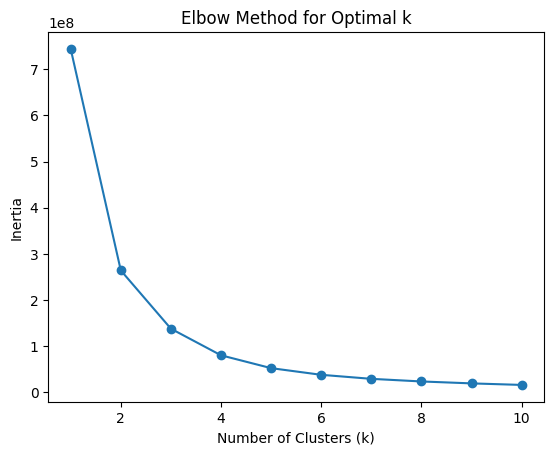

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster  Region                  
0        South East                  2946
         North West                  2338
         London                      1991
         East of England             1943
         West Midlands               1848
         Yorkshire and The Humber    1562
         South West                  1309
         East Midlands               1227
         North East                   848
1        London                       761
         South East                   675
         South West                   662
         East of England              572
         North West                   540
         East Midlands                521
         West Midlands                385
         Yorkshire and The Humber     349
         North East                   218
2        London                      2242
         South East                  1950
         North West                  1689
         Yorkshire and The Humber    1444
         South West                  1436


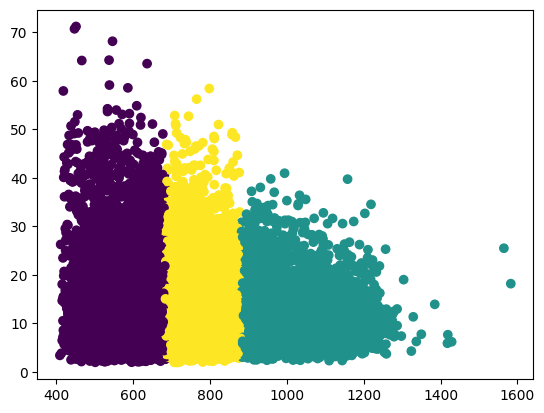

In [14]:
# prompt: clustering

from sklearn.cluster import KMeans

# Select relevant features for clustering
features = df[['Number of households', 'Proportion of households fuel poor (%)']]

# Determine optimal number of clusters using Elbow method
inertia = []
for i in range(1, 11):
  kmeans = KMeans(n_clusters=i, random_state=42)
  kmeans.fit(features)
  inertia.append(kmeans.inertia_)

# Plot Elbow method results
import matplotlib.pyplot as plt
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

# Based on the Elbow method, choose the optimal number of clusters (let's say 3)
optimal_k = 3

# Apply K-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(features)

# Analyze the clusters
print(df.groupby('Cluster')['Region'].value_counts())

# Visualize the clusters (if possible, depending on the nature of the features)
plt.scatter(df['Number of households'], df['Proportion of households fuel poor (%)'], c=df['Cluster'])
plt.show()


In [17]:
# prompt: list top 10 Local Authority with biggest Number of households, and their respective Proportion of households fuel poor (%)

# Sort the DataFrame by 'Number of households' in descending order and select the top 10
top_10_LA = df.sort_values('Number of households', ascending=False).head(10)

# Display the 'Local Authority' and 'Proportion of households fuel poor (%)' for the top 10 LAs
print(top_10_LA[['LA Name', 'Number of households','Proportion of households fuel poor (%)']])


                   LA Name  Number of households  \
1521            Sunderland                1583.0   
3561             Liverpool                1565.0   
24771          Westminster                1429.0   
18950        South Norfolk                1419.0   
8356                 Leeds                1418.0   
12174         West Lindsey                1385.0   
24719          Westminster                1350.0   
18470  North Hertfordshire                1337.0   
4966          South Ribble                1329.0   
24532           Wandsworth                1324.0   

       Proportion of households fuel poor (%)  
1521                                18.193304  
3561                                25.495208  
24771                                6.228000  
18950                                7.681000  
8356                                 5.923000  
12174                               13.935000  
24719                                7.777000  
18470                                6.2820

In [19]:
# prompt: list top 10 LA Name with highest Proportion of households fuel poor (%)

# Sort the DataFrame by 'Proportion of households fuel poor (%)' in descending order and select the top 10
top_10_LA_by_fuel_poverty = df.sort_values('Proportion of households fuel poor (%)', ascending=False).head(10)

# Display the 'Local Authority' and 'Proportion of households fuel poor (%)' for the top 10 LAs
print(top_10_LA_by_fuel_poverty[['LA Name','LSOA Name','Number of households','Proportion of households fuel poor (%)']])


              LA Name            LSOA Name  Number of households  \
12887      Birmingham      Birmingham 096I                 451.0   
15065  Stoke-on-Trent  Stoke-on-Trent 016F                 447.0   
12885      Birmingham      Birmingham 096F                 546.0   
12883      Birmingham      Birmingham 096C                 537.0   
12886      Birmingham      Birmingham 096H                 466.0   
12884      Birmingham      Birmingham 096E                 636.0   
15537         Walsall         Walsall 034D                 538.0   
13293        Coventry        Coventry 015H                 586.0   
12674      Birmingham      Birmingham 047E                 798.0   
13089      Birmingham      Birmingham 139F                 418.0   

       Proportion of households fuel poor (%)  
12887                                  71.175  
15065                                  70.693  
12885                                  68.131  
12883                                  64.245  
12886      

## Let's plot it in graph and see the data first. We can see that West-Midland is having much higher %, followed by Yorkshire and The Humber.

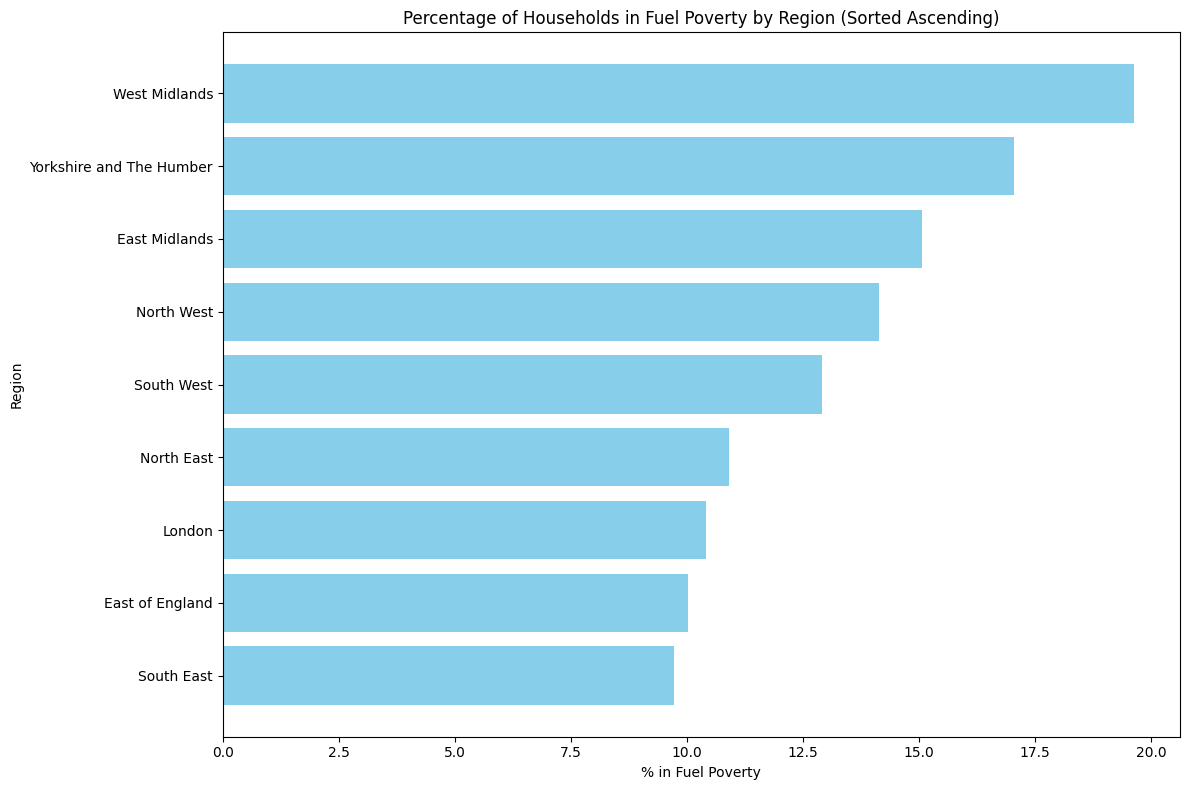

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Sort the DataFrame by '% in fuel poverty' in ascending order
sorted_df = grouped_df.sort_values(by='% in fuel poverty')

# Plot using matplotlib
plt.figure(figsize=(12, 8))
plt.barh(sorted_df['Region'], sorted_df['% in fuel poverty'], color='skyblue')

# Add labels and title
plt.xlabel('% in Fuel Poverty')
plt.ylabel('Region')
plt.title('Percentage of Households in Fuel Poverty by Region (Sorted Ascending)')
plt.tight_layout()

# Show the plot
plt.show()


In [10]:
import matplotlib.pyplot as plt

# Extract the column of interest and remove missing values
fuel_poor_percentages = df['Proportion of households fuel poor (%)'].dropna()

# See the data first
print(fuel_poor_percentages)

0         8.309859
1         7.594937
2        10.278114
3         7.946210
4        11.731044
           ...    
33750     7.785000
33751    10.849000
33752     7.332000
33753    11.065000
33754     5.882000
Name: Proportion of households fuel poor (%), Length: 33755, dtype: float64


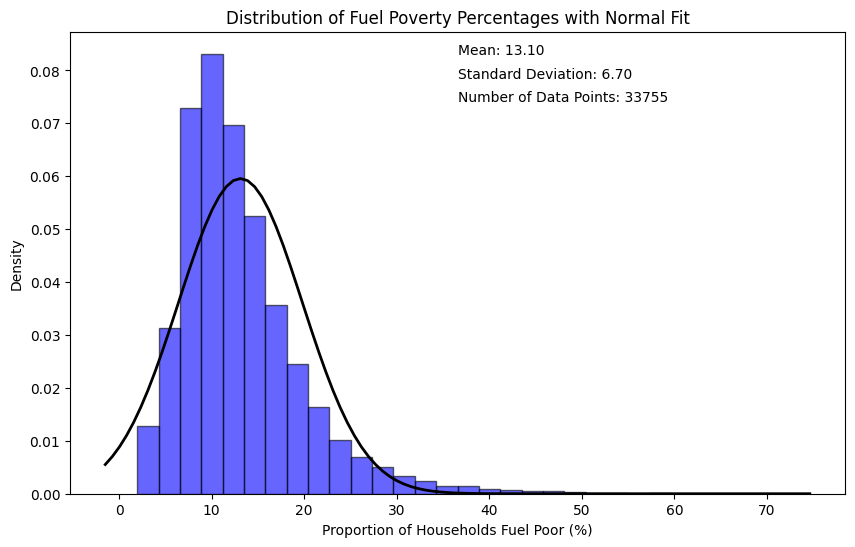

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Extract the column of interest
fuel_poor_percentages = df['Proportion of households fuel poor (%)']

# Convert the column to numeric, coercing errors to NaN
fuel_poor_percentages = pd.to_numeric(fuel_poor_percentages, errors='coerce')

# Drop missing values (NaN)
fuel_poor_percentages = fuel_poor_percentages.dropna()

# Plot the distribution
plt.figure(figsize=(10, 6))
plt.hist(fuel_poor_percentages, bins=30, density=True, alpha=0.6, color='b', edgecolor='black')

# Fit a normal distribution to the data
mu, std = norm.fit(fuel_poor_percentages)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)

# Add labels and title
plt.xlabel('Proportion of Households Fuel Poor (%)')
plt.ylabel('Density')
plt.title('Distribution of Fuel Poverty Percentages with Normal Fit')

# Display mean and standard deviation
plt.text(0.5, 0.95, f'Mean: {mu:.2f}', transform=plt.gca().transAxes)
plt.text(0.5, 0.90, f'Standard Deviation: {std:.2f}', transform=plt.gca().transAxes)
plt.text(0.5, 0.85, f'Number of Data Points: {len(fuel_poor_percentages)}', transform=plt.gca().transAxes)


plt.show()

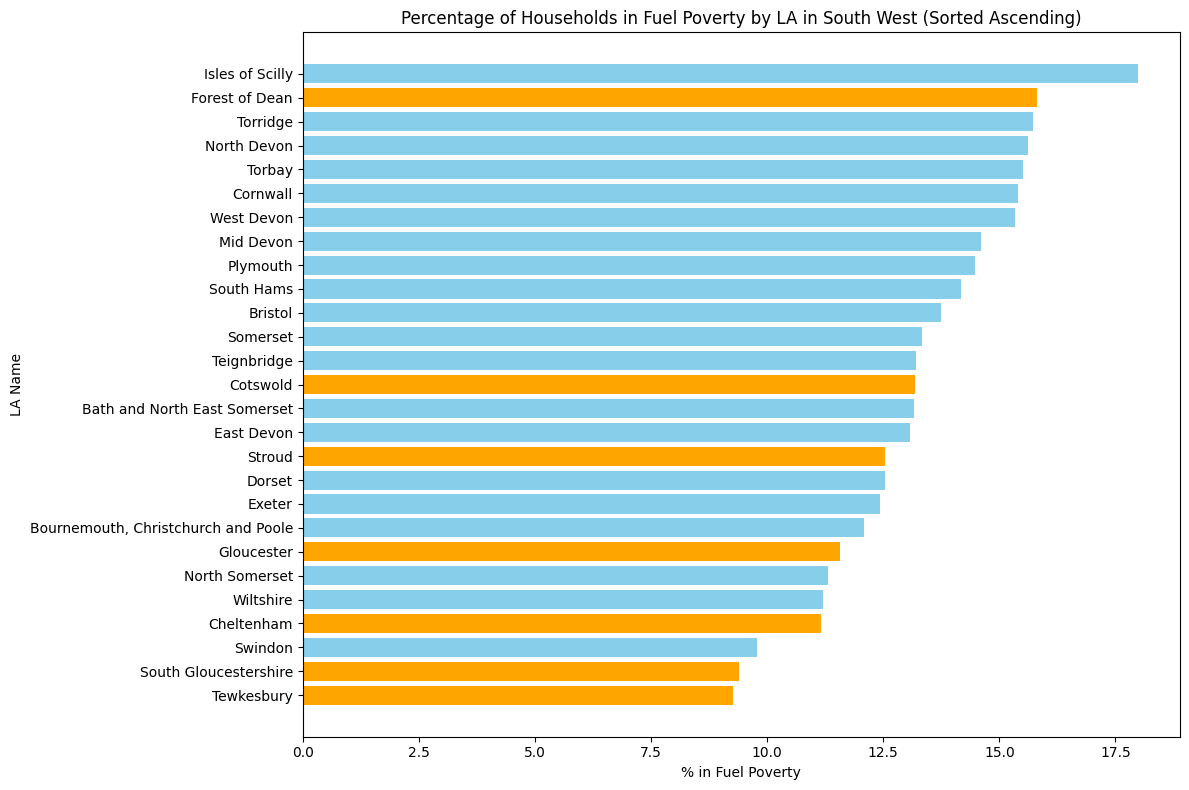

In [12]:
# prompt: from df get all with Region = South West, then groupby LA Name, add up Number of households and Number of households in fuel poverty, respectively
# then calculate % in fuel poverty
# finally generate a chart, and sorted by %, and highlight Cotswold, Forest of Dean, Gloucester, Cheltenham, Stroud, South Gloucestershire, Tewkesbury in orange

import matplotlib.pyplot as plt
# Filter for South West region
south_west_df = df[df['Region'] == 'South West']

# Group by LA Name and sum relevant columns
grouped_sw_df = south_west_df.groupby("LA Name").agg({
    "Number of households": "sum",
    "Number of households in fuel poverty": "sum"
}).reset_index()

# Calculate % in fuel poverty
grouped_sw_df["% in fuel poverty"] = (grouped_sw_df["Number of households in fuel poverty"] / grouped_sw_df["Number of households"]) * 100

# Sort by % in fuel poverty
sorted_sw_df = grouped_sw_df.sort_values(by='% in fuel poverty')

# Highlight specific LAs
highlight_las = ['Cotswold', 'Forest of Dean', 'Gloucester', 'Cheltenham', 'Stroud', 'South Gloucestershire', 'Tewkesbury']
colors = ['orange' if la in highlight_las else 'skyblue' for la in sorted_sw_df['LA Name']]

# Plot the bar chart
plt.figure(figsize=(12, 8))
plt.barh(sorted_sw_df['LA Name'], sorted_sw_df['% in fuel poverty'], color=colors)

# Add labels and title
plt.xlabel('% in Fuel Poverty')
plt.ylabel('LA Name')
plt.title('Percentage of Households in Fuel Poverty by LA in South West (Sorted Ascending)')
plt.tight_layout()

# Show the plot
plt.show()
